# Captcha Bypass

**Team 99**

Pranavbhai Patel

Nicholas Leung

Coden Mercurius

Ravi Singh

**Description**

CAPTCHA, or Completely Automated Public Turing Test to Tell Computers and Humans Apart, is a challenge-response test that determines whether a user is authentic (human) or inauthentic (machine). They require users to authenticate themselves by retyping a character sequence prior to completing a request. This notebook implements a CAPTCHA bypass using deep learning. The team aims to investigate weaknesses and vulnerabilities of the CAPTCHA system.

In [1]:
import torch
import torch.nn as nn
import os
from skimage import io
from torch.utils.data import Dataset, DataLoader
import torch.utils.data
import torchvision 
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time

## Part 1. Data Processing

The dataset for this model is generated using the following library: https://github.com/lepture/captcha. No additional data augmentation is performed at this time. The code used to generate the dataset is found in the team private repo and is named `dataset_generator.py`.

**Current Dataset Characteristics:**
- Uniform distribution of characters used
- Numerical characters only

The generated dataset is availiable through the team private repo. Upload `dataset.zip` into the root session storage and run the below cell to unzip.

In [2]:
!unzip  /content/alphanumeric_dataset.zip -d /content/

Streaming output truncated to the last 5000 lines.
 extracting: /content/alphanumeric_dataset/O1ZTN.png  
 extracting: /content/alphanumeric_dataset/O25K1.png  
 extracting: /content/alphanumeric_dataset/O25S7.png  
 extracting: /content/alphanumeric_dataset/O26T7.png  
 extracting: /content/alphanumeric_dataset/O2947.png  
 extracting: /content/alphanumeric_dataset/O29WA.png  
 extracting: /content/alphanumeric_dataset/O2BTQ.png  
 extracting: /content/alphanumeric_dataset/O2D4L.png  
 extracting: /content/alphanumeric_dataset/O2F3Z.png  
 extracting: /content/alphanumeric_dataset/O2H0L.png  
 extracting: /content/alphanumeric_dataset/O2HG6.png  
 extracting: /content/alphanumeric_dataset/O2IDJ.png  
 extracting: /content/alphanumeric_dataset/O2IWB.png  
 extracting: /content/alphanumeric_dataset/O2JJG.png  
 extracting: /content/alphanumeric_dataset/O2KM9.png  
 extracting: /content/alphanumeric_dataset/O2MIY.png  
 extracting: /content/alphanumeric_dataset/O2NPY.png  
  inflating: /

In [2]:
class CaptchaDataset(Dataset):
  """ Captcha Dataset """

  def __init__(self, directory):
    self.directory = directory
    self.captchas = os.listdir(directory)
    self.captchas.remove("metadata.txt")

    self.transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    self.character_set = open(directory + "/metadata.txt", "r").readline().split(',')
    self.characters_to_identifier = {}

    for i in range(len(self.character_set)):
      self.characters_to_identifier.update({ self.character_set[i]: i })

  def __len__(self):
    # Assumes each file in the dataset directory represents a data sample
    return len(self.captchas)

  def __getitem__(self, index):
    sample_name = self.captchas[index]
    sample_captcha_values = list(sample_name[0:-4]) # Slice s.t. remove png file extension

    # Read the image and represent it as a tensor
    image = io.imread(self.directory + '/' + sample_name)
    image = self.transform(image)

    # Represent each character as an integer identifier
    label = []
    for char in sample_captcha_values:
      label.append(self.characters_to_identifier.get(char))

    return (image, torch.tensor(label))

In [3]:
dataset_path = "/content/alphanumeric_dataset"

# Instantiate dataset
dataset = CaptchaDataset(dataset_path)

In [4]:
def visualize_character_frequency(dataloader, title):
  character_frequency = {} # Contains frequency information
  character_set = dataset.character_set

  # Populate character_frequency
  for _, labels in dataloader:
    for label in labels:
      for char_identifier in label:
        char = character_set[char_identifier.item()]
        current_value = character_frequency.get(char, None)

        if current_value is None: 
          character_frequency.update({ char : 0 })
        else:
          character_frequency.update({ char : current_value + 1 })

  x_values = range(len(character_set))
  y_values = []

  for char in character_set:
    count = character_frequency.get(char)
    y_values.append(count)

  plt.title(title)
  plt.plot(x_values, y_values)
  plt.xlabel("Characters")
  plt.ylabel("Count")
  plt.xticks(x_values, character_set)
  plt.show()

In [5]:
def get_data_loaders(dataset, batch_size, total_size=None):

  if total_size is None:
    total_size = len(dataset)

  training_ratio = 0.7
  validation_ratio = 0.15
  # test_ratio implied

  train_length = int(total_size * training_ratio)
  validation_length = int((total_size - train_length) * (validation_ratio / ( 1 - training_ratio )))
  test_length = total_size - train_length - validation_length
  fill = len(dataset) - total_size
  
  train_set, valid_set, test_set, fill_set = torch.utils.data.random_split(dataset, [train_length, validation_length, test_length, fill], torch.Generator().manual_seed(10))

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1, drop_last=True, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, num_workers=1, drop_last=True, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1, drop_last=True, shuffle=True)

  return train_loader, valid_loader, test_loader

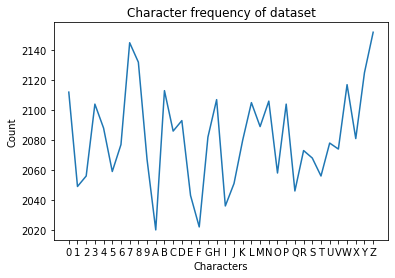

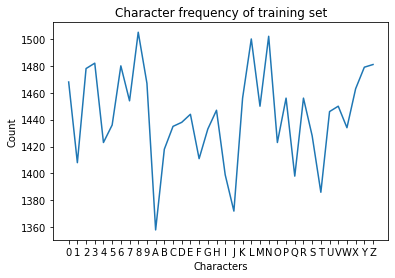

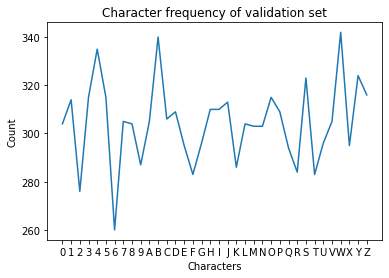

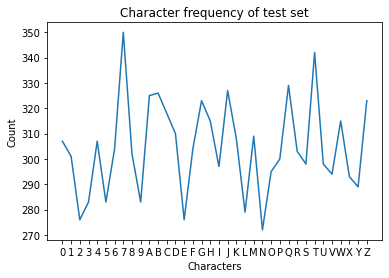

In [6]:
# Dataset visualization
train, valid, test = get_data_loaders(dataset, 100)

visualize_character_frequency(torch.utils.data.DataLoader(dataset, num_workers=1), title="Character frequency of dataset")
visualize_character_frequency(train, title="Character frequency of training set")
visualize_character_frequency(valid, title="Character frequency of validation set")
visualize_character_frequency(test, title="Character frequency of test set")

## Part 2: CAPTCHA Segmentation

In [7]:
import random
import cv2
import torchvision as tv

In [8]:
def processimage(image, thresh):
      #Format image type/ dimensions
      image=image.permute(1,2,0)
      image=image.numpy()
      imageorig=image
      
      #Modify image so contours/ borders can be easily found
      #Greyscale
      image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
      #Binary Threshold
      NA, image = cv2.threshold(image, thresh, 1, cv2.THRESH_BINARY)
      #Erosion
      kernel = np.ones((2,2),np.uint8)
      image = cv2.dilate(image,kernel,iterations = 1)
      #Vertical Blur and Resharpen
      morpher = cv2.getStructuringElement(cv2.MORPH_RECT, (1,3))
      image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, morpher)
      #Binary Threshold  
      thresh, image = cv2.threshold(image,thresh, 1, cv2.THRESH_BINARY)
      #Expand Border
      image=cv2.copyMakeBorder(image, 5, 5, 5, 5,cv2.BORDER_CONSTANT,value=1)
      image = image.astype(np.uint8)

      return imageorig,image

In [9]:
def segmentimage(image,narrow):
    #Return list of borderlines in image
    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #imagecont=cv2.drawContours(image, contours, -1, (0, 0.5, 0), 1)

    #Creates boxes for every large object
    boxes=[]
    for contour in contours:
        [x,y,w,h]=cv2.boundingRect(contour)
        if(w>8 and w<120 and h>30):
          boxes.append([x,y,w,h])
    boxes.sort(key=lambda x: x[0])

    #Eliminates boxes that are contained whithin other boxes (subparts of a letter)
    i=1
    while (i<len(boxes)):
      box=boxes[i]
      boxprev=boxes[i-1]
      if (box[0]>boxprev[0] and box[1]>boxprev[1] and (box[0]+box[2])<(boxprev[0]+boxprev[2]) and (box[1]+box[3])<(boxprev[1]+boxprev[3])):
        boxes.pop(i)
        i-=1
      i+=1

    #If boxes are too wide they may contain multiple boxes 
    #They are split vertically into 2 or 3 subboxes (even width splits)
    i=0
    while (i<len(boxes)):
      box=boxes[i]
      if (box[2]>box[3]*(0.95-narrow)):
        x,y,w,h=boxes.pop(i)
        boxes.insert(i,[x+int((2*w)/3),y,int(w/3),h])
        boxes.insert(i,[x+int((w)/3),y,int(w/3),h])
        boxes.insert(i,[x,y,int(w/3),h])
      elif (box[2]>box[3]*(0.6-narrow)):
        x,y,w,h=boxes.pop(i)
        boxes.insert(i,[x+int(w/2),y,int(w/2),h])
        boxes.insert(i,[x,y,int(w/2),h])
      if (i>=len(boxes)-1):
        break
      i+=1
    
    return boxes

In [10]:
def getcharacterimages(images, showsegments=False, filterBadSegmentation=False, imgsize=80):
  characters=[]
  for i in range (0,len(images)):
    imageraw = images[i]
 
    # CAPTCHA image pre-processed, custom function called
    # Rectangle Borders of each character obtained, custom function called
    for i in range(0,7):
      thresh, narrow = 0.6,0
      if (i>=1):
        narrow=0.1
        thresh=0.6+(i-1)*0.1
      imageorig, image=processimage(imageraw,thresh)
      imageboxes = np.copy(image)
      boxes=segmentimage(image,narrow)
      if (len(boxes)>=5):
        break

    # Filter bad segmentation cases
    if filterBadSegmentation and len(boxes) < 5:
      continue
      
    # Individual Characters images are cut out from CAPTCHA image
    charactersset=[]
    for i in range(0,5):
      # If insufficient letters obtainable, add an empty image
      if (i<len(boxes)):
        box=boxes[i]
      else:
        box=[0,0,1,1]

      [x,y,w,h]=box
      char=image[y:y+h,x:x+w]
      height=char.shape[0]
      width=char.shape[1]
      # cv2.copyMakeBorder(soruce, top, bottom, left, right, borderType, value)
      if (width>height):
        char=cv2.copyMakeBorder(char, int ((width-height)/2),int ((width-height)/2), 0, 0,cv2.BORDER_CONSTANT,value=1)
      if (height>width):
        char=cv2.copyMakeBorder(char,0,0, int ((height-width)/2), int ((height-width)/2),cv2.BORDER_CONSTANT,value=1)
      char = cv2.resize(char, dsize=(imgsize, imgsize), interpolation=cv2.INTER_CUBIC)
      char=torch.Tensor(char)
      charactersset.append(char)
      cv2.rectangle(imageboxes,(x,y),(x+w,y+h),0,1)
    charactersset=torch.stack(charactersset)
    characters.append(charactersset)
    
    if (showsegments==True):
      plt.imshow(imageorig)
      plt.show()
      plt.imshow(imageboxes, cmap='gray', vmin = 0, vmax = 1)
      plt.show()
      for i in range(0,5):
        plt.subplot(1,5,i+1)
        plt.imshow(charactersset[i], cmap='gray', vmin = 0, vmax = 1)
      plt.show()

  return torch.stack(characters)

In [11]:
"""
How To Use - getcharacterimages(images, showsegments=False)

Input = tensor(batchsize,numchannels,height,width) (see below)
Output = tensor(batchsize, numcharacters = 5, height = 80, width = 80 )

Turn showsegments on to visualize segmentation process
"""
train, valid, test = get_data_loaders(dataset, 100)

images_processed = 0
successful_segmentation = 0

for images, labels in train:
  characters = getcharacterimages(images, False, True)
  images_processed = images_processed + len(labels)
  successful_segmentation = successful_segmentation + len(characters)

print(f"Successful segmentation accuracy: { successful_segmentation / images_processed }")

Successful segmentation accuracy: 0.9704807692307692


In [12]:

# NO LONGER USED
CNN_train, CNN_valid, CNN_test = [], [], []

for images, labels in train:
    CNN_train.append((getcharacterimages(images, False, imgsize=28), labels))
CNN_train = CNN_train[:len(CNN_train)-1]

for images, labels in valid:
    CNN_valid.append((getcharacterimages(images, False, imgsize=28), labels))
CNN_valid = CNN_valid[:len(CNN_valid)-1]

for images, labels in test:
    CNN_test.append((getcharacterimages(images, False, imgsize=28), labels))
CNN_test = CNN_test[:len(CNN_test)-1]

## Part 3. Base Model

The base model for our captcha solver is a completely non-deep learning method. The model consists of a module for segmentation and a module for individual character classification, similar to the primary model. For segmentation, we use the OpenCV Contours implementation previously defined. For classification of individual characters, we use SVM. 

In [13]:
from sklearn import svm
import numpy as np

In [14]:
class BaseModel:

  def __init__(self):
    self.classifier = svm.SVC()

  def fit_classifier(self, dataloader):

    # Preprocessing to make our PyTorch data in acceptable format

    input_acc = []
    labels_acc = []

    for images, labels in dataloader:

      segmented_captchas = getcharacterimages(images, imgsize=28)

      # Iterate over each captcha
      for i in range(len(segmented_captchas)):
        captcha = segmented_captchas[i]
        
        # Iterate over each character
        for j in range(len(captcha)):
          input_acc.append(captcha[j].detach().numpy().reshape(-1))
          labels_acc.append(labels[i][j].detach().numpy())
    
    input_acc = np.array(input_acc)
    labels_acc = np.array(labels_acc)

    # Train character classification

    self.classifier.fit(input_acc, labels_acc)

  def predict(self, images):
    segmented_captchas = getcharacterimages(images, imgsize=28)

    output = []
    for captcha in segmented_captchas:

      out_captcha = []

      for character in captcha:
        numpy_char = character.detach().numpy().reshape((1, -1)) # Reshape to acceptable input for SVM predict()
        out_char = self.classifier.predict(numpy_char)
        out_captcha.append(out_char.item())
      
      output.append(out_captcha)

    return torch.tensor(output)


### Model Fitting

The model is fitted on the training set. The "learnable" portion of the model is the character classifier which learns based off of the segmented characters.

In [15]:
model = BaseModel()
train_small, valid_small, test_small = get_data_loaders(dataset, 100, 3000)

model.fit_classifier(train_small)

### Model Performance

The base model can be used for prediction by calling model.predict(input). The input is a mini-batch defined as a tensor. Internally, the model will convert the tensor format to a format SVM accepts.

In [16]:
def evaluate_base_model(dataloader):

  total_character_guesses = 0
  total_captcha_guesses = 0

  incorrect_character_guesses = 0
  incorrect_captcha_guesses = 0

  failed_guess_frequency = {}

  for images, labels in dataloader:
    out = model.predict(images)

    # Iterate through each sample captcha in batch
    for i in range(len(labels)):
      bad_guess = False

      # Iterate through each character of captcha
      for j in range(len(labels[i])):

        total_character_guesses = total_character_guesses + 1
        guess = out[i][j]
        expected = labels[i][j]

        if (guess != expected):
          incorrect_character_guesses = incorrect_character_guesses + 1

          # Track per character bad guesses
          current_failed_guess_count = failed_guess_frequency.get(dataset.character_set[guess], 0)
          failed_guess_frequency.update({ dataset.character_set[guess]: current_failed_guess_count + 1 })

          bad_guess = True
      
      if bad_guess:
        incorrect_captcha_guesses = incorrect_captcha_guesses + 1
      
      total_captcha_guesses = total_captcha_guesses + 1

  # Overall accuracy information

  character_guess_accuracy = (total_character_guesses - incorrect_character_guesses) / total_character_guesses
  captcha_guess_accuracy = (total_captcha_guesses - incorrect_captcha_guesses) / total_captcha_guesses
  
  print(f"Character Guess Accuracy: {character_guess_accuracy}")
  print(f"Captcha Guess Accuracy: {captcha_guess_accuracy}")

  # Plot incorrect character guess frequency

  bad_guess_character_set = failed_guess_frequency.keys()

  x_values = range(len(bad_guess_character_set))
  y_values = []

  for char in bad_guess_character_set:
    count = failed_guess_frequency.get(char)
    y_values.append(count)

  plt.title("Bad guess character frequency")
  plt.plot(x_values, y_values)
  plt.xlabel("Characters")
  plt.ylabel("Count")
  plt.xticks(x_values, bad_guess_character_set)
  plt.show()



Base Model Performance on Validation Set
Character Guess Accuracy: 0.8169090909090909
Captcha Guess Accuracy: 0.5027272727272727


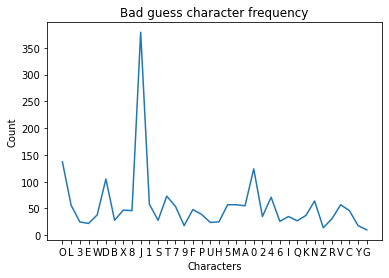

In [17]:
print("Base Model Performance on Validation Set")
acc = evaluate_base_model(valid)

## Part 4: Primary Model

In [18]:
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

In [19]:
use_cuda = True

In [20]:
# Sample CNN based on Lab 2 model
class CaptchaCNN(nn.Module):
    def __init__(self):
        super(CaptchaCNN, self).__init__()
        self.name = "CaptchaCNN"

        # 5 chars, 5,5 we decide
        self.conv1 = nn.Conv2d(1, 5, 5)
        # w,h = 
        self.pool1 = nn.MaxPool2d(2, 2)
        # w,h = 

        # 5 matches the second 5 from the first CNN layer
        self.conv2 = nn.Conv2d(5, 10, 5)
        # w,h =
        self.pool2 = nn.MaxPool2d(2,2)
        # w,h = 

        self.fc1 = nn.Linear(160, 32)
        self.fc2 = nn.Linear(32, 36)

    def forward(self, img):
        x = getcharacterimages(img, False, imgsize=28)
        x = x.reshape(-1, 1, 28, 28)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 160)
        return self.fc2(F.relu(self.fc1(x)))

In [21]:
def plot(title, xlabel, ylabel, data1, data1_label, data2, data2_label, epochs):
    plt.title(title)
    plt.plot(epochs, data1, label=data1_label)
    if data2 is not None:
      plt.plot(epochs, data2, label=data2_label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.show()

In [22]:
captcha_length = 5
batch_size = 32

In [23]:
def get_accuracy(model, data_loader):
  total = 0
  correct = 0
  char_correct = 0
  for imgs, labels in data_loader:
      if torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
      for i in range(batch_size):
        output = model(imgs[i].unsqueeze(dim=0))
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        num_correct = 0
        for j in range(captcha_length): 
          # print(labels[i][j])
          # print(pred[j])
          if labels[i][j] == pred[j].squeeze(0):
            num_correct += 1
            char_correct += 1
          # print(num_correct)
        if num_correct == 5:
          correct += 1
        total += 1
  return correct / total, char_correct / (5 * total)

In [24]:
def get_model_name(name, epoch, learning_rate=1e-4):
  """
  Generate a name for the model consisting of all the hyperparameter values
  """
  path="model_{0}_lr{1}_epoch{2}".format(
      name, learning_rate, epoch)
  return path

In [25]:
def train_cnn(model, x, y, batch_size=128, num_epochs=20, learning_rate=0.001):
    torch.manual_seed(360)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = x
    valid_loader = y

    iters = []
    losses = []
    train_acc = []
    valid_acc = []

    epoch = 0

    for epoch in range(num_epochs):
        for img, label in train_loader:  
            label = label.reshape(-1)
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            out = model(img) # forward pass
            loss = criterion(out, label) # compute the total loss
            loss.backward()  # backward pass (compute parameter updates)
            optimizer.step()  # make the updates for each parameter
            optimizer.zero_grad()  # a clean up step for PyTorch

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, epoch, learning_rate=learning_rate)
        torch.save(model.state_dict(), model_path)

        # save the current training information
        iters.append(epoch)
        losses.append(float(loss))  # compute *average* loss
        captcha_acc, char_acc = get_accuracy(model, train_loader)
        print(char_acc)
        train_acc.append(captcha_acc)  # compute training accuracy
        if y != None:
            valid_acc.append(
                get_accuracy(model, valid_loader)[0]
            )  # compute validation accuracy
        if y != None:
            print(
                (
                    "Epoch {}: Training accuracy: {}, " + "Validation accuracy: {}"
                ).format(epoch + 1, train_acc[epoch], valid_acc[epoch])
            )
        else:
            print(
                ("Epoch {}: Training accuracy: {}").format(epoch + 1, train_acc[epoch])
            )
        epoch += 1

        # model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        # torch.save(model.state_dict(), model_path)
    plt.title("Loss")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Accuracy")
    plt.plot(iters, train_acc, label="Train")
    if y != None:
        plt.plot(iters, valid_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.show()

    if y != None:
        return losses, train_acc, valid_acc
    return losses, train_acc

In [ ]:
model = CaptchaCNN()
train, valid, test = get_data_loaders(dataset, batch_size)
losses, train_acc, valid_acc = train_cnn(model, train, valid, batch_size, 30, 0.001)

0.6893483231707317
Epoch 1: Training accuracy: 0.21789253048780488, Validation accuracy: 0.221875
0.7740282012195122
Epoch 2: Training accuracy: 0.3842416158536585, Validation accuracy: 0.3732142857142857
0.8030678353658537
Epoch 3: Training accuracy: 0.4496951219512195, Validation accuracy: 0.4486607142857143
0.8171112804878049
Epoch 4: Training accuracy: 0.4889481707317073, Validation accuracy: 0.4830357142857143
0.8213795731707317
Epoch 5: Training accuracy: 0.49904725609756095, Validation accuracy: 0.496875
0.8311547256097561
Epoch 6: Training accuracy: 0.5290586890243902, Validation accuracy: 0.5169642857142858


## Part 5: AlexNet Transfer Learning

In [27]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

AlexNet_train, AlexNet_valid, AlexNet_test = [], [], []

train, valid, test = get_data_loaders(dataset, 100)

for images, labels in train:
    AlexNet_train.append((getcharacterimages(images, False, imgsize=80), labels))
AlexNet_train = AlexNet_train[:len(AlexNet_train)-1]

for images, labels in valid:
    AlexNet_valid.append((getcharacterimages(images, False, imgsize=80), labels))
AlexNet_valid = AlexNet_valid[:len(AlexNet_valid)-1]

for images, labels in test:
    AlexNet_test.append((getcharacterimages(images, False, imgsize=80), labels))
AlexNet_test = AlexNet_test[:len(AlexNet_test)-1]

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


KeyboardInterrupt: ignored

In [ ]:
imgs_train, labels_train = [], []
imgs_valid, labels_valid = [], []
imgs_test, labels_test = [], []

for img, label in AlexNet_train:
    img_grey = img.reshape(-1, 1, 80, 80)
    label = label.reshape(-1)
    img_color = img_grey.repeat(1,3,1,1)
    features = torch.from_numpy(alexnet.features(img_color).detach().numpy())
    imgs_train.append(features)
    labels_train.append(label)

for img, label in AlexNet_valid:
    img = img.reshape(-1, 1, 80, 80)
    label = label.reshape(-1)
    img_color = img.repeat(1,3,1,1)
    features = torch.from_numpy(alexnet.features(img_color).detach().numpy())
    imgs_valid.append(features)
    labels_valid.append(label)

for img, label in AlexNet_test:
    img = img.reshape(-1, 1, 80, 80)
    label = label.reshape(-1)
    img_color = img.repeat(1,3,1,1)
    features = torch.from_numpy(alexnet.features(img_color).detach().numpy())
    imgs_test.append(features)
    labels_test.append(label)

AlexNet_train = list(zip(imgs_train, labels_train))
AlexNet_valid = list(zip(imgs_valid, labels_valid))
AlexNet_test = list(zip(imgs_test, labels_test))

In [ ]:
def get_accuracy_alexnet(model, data_loader):
  total = 0
  correct = 0
  char_correct = 0
  for imgs, labels in data_loader:
      if torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
      output = model(imgs)
      pred = output.max(1, keepdim=True)[1].squeeze(1) # get the index of the max logit
      for i in range(0, len(output), captcha_length):
        num_correct = 0
        for j in range(captcha_length):
          if labels[i+j] == pred[i+j]:
            num_correct += 1
            char_correct += 1
        if num_correct == 5:
          correct += 1
        total += 1
  return correct / total, char_correct / (5 * total)

def train_alexnet(model, x, y, batch_size=128, num_epochs=20, learning_rate=0.001):
    torch.manual_seed(360)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = x
    valid_loader = y

    iters = []
    losses = []
    train_acc = []
    valid_acc = []

    epoch = 0

    for epoch in range(num_epochs):
        for img, label in train_loader:  
            if use_cuda and torch.cuda.is_available():
                img = img.cuda()
                label = label.cuda()
            out = model(img) # forward pass
            loss = criterion(out, label) # compute the total loss
            loss.backward()  # backward pass (compute parameter updates)
            optimizer.step()  # make the updates for each parameter
            optimizer.zero_grad()  # a clean up step for PyTorch

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, epoch, learning_rate=learning_rate)
        torch.save(model.state_dict(), model_path)

        # save the current training information
        iters.append(epoch)
        losses.append(float(loss))  # compute *average* loss
        captcha_acc, char_acc = get_accuracy_alexnet(model, train_loader)
        train_acc.append(captcha_acc)  # compute training accuracy
        if y != None:
            captcha_acc, char_acc = get_accuracy_alexnet(model, valid_loader)  # compute validation accuracy
            print(f"char_acc = {char_acc}")
            valid_acc.append(captcha_acc)
        if y != None:
            print(
                (
                    "Epoch {}: Training accuracy: {}, " + "Validation accuracy: {}"
                ).format(epoch + 1, train_acc[epoch], valid_acc[epoch])
            )
        else:
            print(
                ("Epoch {}: Training accuracy: {}").format(epoch + 1, train_acc[epoch])
            )
        epoch += 1

        # model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        # torch.save(model.state_dict(), model_path)
    plt.title("Loss")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Accuracy")
    plt.plot(iters, train_acc, label="Train")
    if y != None:
        plt.plot(iters, valid_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.show()

    if y != None:
        return losses, train_acc, valid_acc
    return losses, train_acc

In [ ]:
class AlexNetANNClassifier(nn.Module):
    def __init__(self):
        super(AlexNetANNClassifier, self).__init__()
        self.name = "AlexNetANNClassifier"
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 36)

    def forward(self, img):
        x = img.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

char_acc = 0.4465
Epoch 1: Training accuracy: 0.0275, Validation accuracy: 0.0325
char_acc = 0.575
Epoch 2: Training accuracy: 0.087, Validation accuracy: 0.11
char_acc = 0.637
Epoch 3: Training accuracy: 0.174, Validation accuracy: 0.155
char_acc = 0.675
Epoch 4: Training accuracy: 0.2225, Validation accuracy: 0.2125
char_acc = 0.6885
Epoch 5: Training accuracy: 0.2715, Validation accuracy: 0.245
char_acc = 0.701
Epoch 6: Training accuracy: 0.302, Validation accuracy: 0.2675
char_acc = 0.707
Epoch 7: Training accuracy: 0.3295, Validation accuracy: 0.285
char_acc = 0.711
Epoch 8: Training accuracy: 0.3455, Validation accuracy: 0.2825
char_acc = 0.7065
Epoch 9: Training accuracy: 0.3575, Validation accuracy: 0.27
char_acc = 0.7195
Epoch 10: Training accuracy: 0.3825, Validation accuracy: 0.285
char_acc = 0.7225
Epoch 11: Training accuracy: 0.387, Validation accuracy: 0.3
char_acc = 0.728
Epoch 12: Training accuracy: 0.395, Validation accuracy: 0.3075
char_acc = 0.7285
Epoch 13: Training

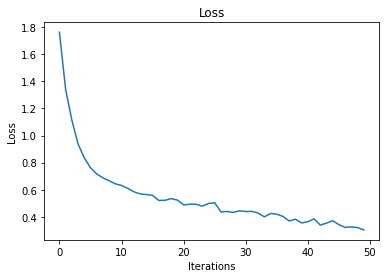

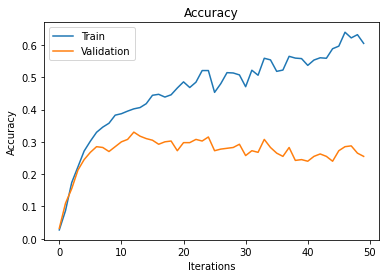

In [ ]:
model = AlexNetANNClassifier()
if torch.cuda.is_available():
    model.cuda()

losses, train_acc, valid_acc = train_alexnet(model, AlexNet_train, AlexNet_valid, 100, 50, 5e-3)

## Part 6: End-to-End System

* decoding value -> char
* wrapper for model
* function(CAPTCHA_Image) => character string
  * Segmentation
  * CNN Model
  * Output prediction
  * Print input CAPTCHA

In [ ]:
def decodeCharacter (encodedValue):
  if (encodedValue < 10):
    return encodedValue
  else:
    return chr(encodedValue + 55)

In [ ]:
def e2emodel (input_image, input_labels):
  model = CaptchaCNN()
  model.load_state_dict(torch.load(get_model_name(model.name, epoch=20, learning_rate=0.005)))

  imgs = input_image
  labels = input_labels

  # Plot batch of images
  fig = plt.figure(figsize=(28, 28))
  for idx in np.arange(5):
      ax = fig.add_subplot(3, 9, idx+1, xticks=[], yticks=[])
      plt.imshow(imgs[idx])
      ax.set_title(labels[idx])

  # Prediction
  out = model(imgs.reshape(-1, 1, 28, 28))
  pred = out.max(1, keepdim=True)[1].squeeze(1).tolist()
  CAPTCHA_prediction = list(map(decodeCharacter, pred))
  print(f"Predicted output = {CAPTCHA_prediction}")

Predicted output = ['P', 'F', 1, 'Z', 'J']


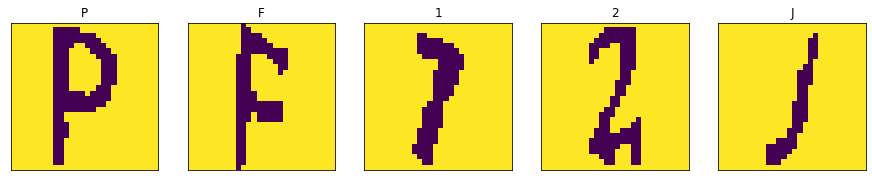

In [ ]:
# Random sample from CNN_test
rand_batch = random.randint(0, len(CNN_test)-1)
rand_sample = random.randint(0, len(CNN_test[0][0])-1)

# Pass into e2e model
imgs = CNN_test[rand_batch][0][rand_sample]
labels = list(map(decodeCharacter, CNN_test[rand_batch][1][rand_sample].tolist()))
e2emodel(imgs, labels)